In [33]:
# NOTE: You will need to update this to the directory where you
# generate data.
DATA_BASE_DIR = '../data'
# Update this to where you want to save the trained model.
MODEL_SAVE_DIR = '../models_test'

In [10]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import gc
import time

In [11]:
# batch_size = 30
# filepaths = sorted(glob.glob('../data_depth8*/board*.csv'))
# filepath = filepaths[0]
# print(filepath)

# column_names = [f'c{i}' for i in range(14*14*4)]
# ds = tf.data.experimental.make_csv_dataset(
#     filepath, shuffle=False, batch_size=batch_size,
#     column_names=column_names)

In [12]:
def load_files(filepattern):
    filepaths = sorted(glob.glob(filepattern))
    np_data = []
    for filepath in filepaths:
        np_data.append(np.genfromtxt(filepath, delimiter=','))
    np_data = np.concatenate(np_data, axis=0)
    return np_data

In [15]:
start = time.time()

board_np = load_files(os.path.join(DATA_BASE_DIR, 'board*.csv')).astype(np.int32)
per_depth_score_np = load_files(os.path.join(DATA_BASE_DIR, 'per_depth_score*.csv')).astype(np.int32)
score_np = load_files(os.path.join(DATA_BASE_DIR, 'score*.csv')).astype(np.int32)
result_np = load_files(os.path.join(DATA_BASE_DIR, 'game_result*.csv')).astype(np.int32)

print('board shape:', board_np.shape)
print('score shape:', score_np.shape)
print('per-depth score shape:', per_depth_score_np.shape)
print('result shape:', result_np.shape)
assert board_np.shape[0] == score_np.shape[0]
assert board_np.shape[0] == per_depth_score_np.shape[0]
assert board_np.shape[0] == result_np.shape[0]

duration = time.time() - start
print(f'data-loading duration(sec): {duration:.02f}')

board shape: (11421, 784)
score shape: (11421,)
per-depth score shape: (11421, 5)
result shape: (11421,)
data-loading duration(sec): 3.80


In [16]:
# Scores are in centipawns
# A score of 10000 should be mostly winning (~90%)
def convert_scores_to_probs(scores):
    denom = -10 / np.log(1/.9 - 1)
    score = scores / 100 / denom
    return tf.math.sigmoid(score).numpy()

probs = convert_scores_to_probs(score_np)
per_depth_probs = [convert_scores_to_probs(per_depth_score_np[:, i])
                   for i in range(per_depth_score_np.shape[1])]

In [18]:
def convert_probs_to_scores(probs):
    epsilon = 1e-8
    prob = np.maximum(epsilon, np.minimum(1-epsilon, probs))
    d = -10 / np.log(1/.9-1)
    return 100 * d * np.log(prob/(1-prob))

In [20]:
a = score_np
b = per_depth_score_np[:,-1]
# Sanity check: is the data loaded properly?
# If this fails, the file orders for each data type are probably mismatched.
assert np.sum(a != b) == 0

In [22]:
def mae(x, y):
    return np.mean(np.abs(x - y))

# Ideally the trained neural network will get MAE lower than
# one of the below from actual search on each depth.
for i in range(len(per_depth_probs)):
    print('depth:', i, 'mae:', mae(per_depth_probs[i], probs))

depth: 0 mae: 0.30240244845470676
depth: 1 mae: 0.08128037561029564
depth: 2 mae: 0.056995412259817635
depth: 3 mae: 0.054975367245619536
depth: 4 mae: 0.0


In [27]:
inputs = board_np.reshape((-1, 4, 14*14))
# Weight the final game result and the search score together to
# create a target (still in [0, 1]).
result_prob = (result_np + 1) / 2.0
assert np.amin(result_prob) >= 0
assert np.amax(result_prob) <= 1
targets = 0.5 * probs + 0.5 * result_prob

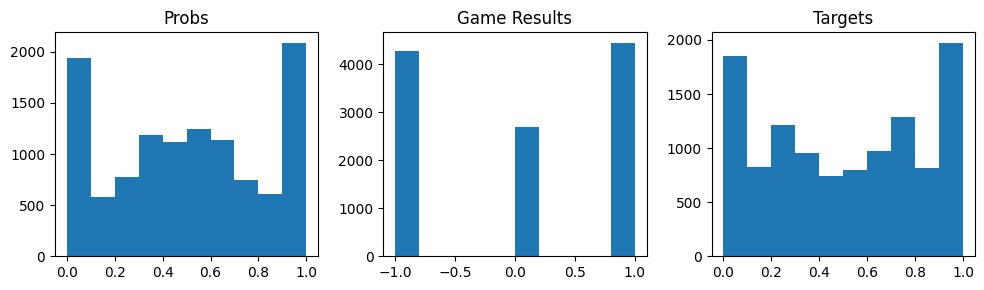

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].hist(probs)
ax[0].set_title('Probs')
ax[1].hist(result_np)
ax[1].set_title('Game Results')
ax[2].hist(targets)
ax[2].set_title('Targets')

plt.tight_layout()
plt.show()

In [37]:
size = board_np.shape[0]

num_train = int(.9 * size)
inputs_train = inputs[:num_train]
targets_train = targets[:num_train]

inputs_val = inputs[num_train:]
targets_val = targets[num_train:]
print('# Train:', num_train)
print('# Val:', size - num_train)

# Train: 10278
# Val: 1143


In [38]:
def one_hot_layer(x):
    y = tf.one_hot(x, 7)
    y = tf.where(tf.expand_dims(x, -1) != 0, y, 0)
    return tf.reshape(y, (-1, 4, 14*14*7))

model = tf.keras.Sequential(layers=[
  # (rows x cols,)
  tf.keras.Input(shape=(4, 14*14), dtype=tf.int32),
  tf.keras.layers.Lambda(one_hot_layer),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1),
])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 4, 1372)           0         
                                                                 
 dense (Dense)               (None, 4, 32)             43936     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 49,153
Trainable params: 49,153
Non-traina

In [39]:
gc.collect()

10229

In [40]:
history = model.fit(inputs_train, targets_train, epochs=50,
                    validation_data=(inputs_val, targets_val),
                    batch_size=2048,
                    verbose=1)

Epoch 1/50


2023-05-30 21:32:28.883128: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8ecfeecc50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-30 21:32:28.883158: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-05-30 21:32:28.883163: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-05-30 21:32:28.887314: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-30 21:32:28.997858: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 [==============================] - 2s 53ms/step - loss: 0.2485 - mean_absolute_error: 0.4071 - val_loss: 0.1593 - val_mean_absolute_error: 0.3309
Epoch 2/50
6/6 [==============================] - 0s 12ms/step - loss: 0.1223 - mean_absolute_error: 0.2975 - val_loss: 0.1234 - val_mean_absolute_error: 0.2970
Epoch 3/50
6/6 [==============================] - 0s 12ms/step - loss: 0.1058 - mean_absolute_error: 0.2697 - val_loss: 0.0943 - val_mean_absolute_error: 0.2662
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0757 - mean_absolute_error: 0.2359 - val_loss: 0.0902 - val_mean_absolute_error: 0.2557
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0630 - mean_absolute_error: 0.2108 - val_loss: 0.0778 - val_mean_absolute_error: 0.2344
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0479 - mean_absolute_error: 0.1808 - val_loss: 0.0681 - val_mean_absolute_error: 0.2168
Epoch 7/50
6/6 [=============================

In [41]:
print('MAE:', history.history['mean_absolute_error'][-1])
print('Val MAE:', history.history['val_mean_absolute_error'][-1])

MAE: 0.04773726314306259
Val MAE: 0.1162852793931961


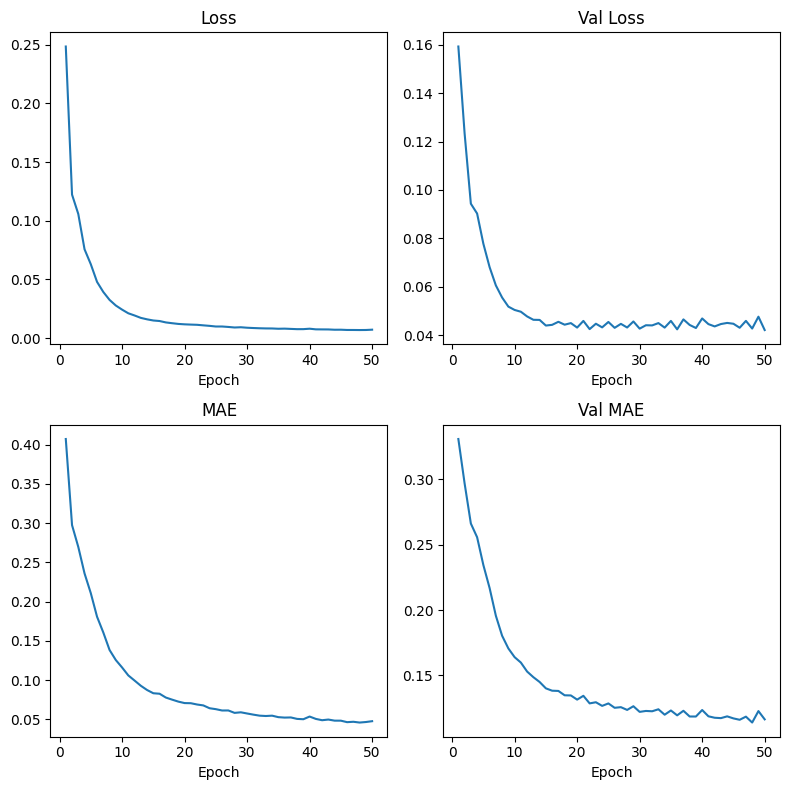

In [42]:
def LinePlot(ax, title, values):
    ax.plot(1 + np.arange(len(values)), values)
    ax.set_title(title)
    ax.set_xlabel('Epoch')

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
LinePlot(ax[0, 0], 'Loss', history.history['loss'])
LinePlot(ax[0, 1], 'Val Loss', history.history['val_loss'])
LinePlot(ax[1, 0], 'MAE', history.history['mean_absolute_error'])
LinePlot(ax[1, 1], 'Val MAE', history.history['val_mean_absolute_error'])
fig.tight_layout()

In [47]:
model.save(os.path.join(MODEL_SAVE_DIR, 'nnue.h5'), save_format='h5')

In [48]:
#model.load_weights('../models/nnue.h5')

In [49]:
# Save the weights to CSV.
# Ideally we would save them to a more performant file format like h5,
# however reading h5 in C++ requires extra libraries.

output_dir = MODEL_SAVE_DIR

def save_weights(filename, np_arr):
    full_filepath = os.path.join(output_dir, filename)
    if os.path.exists(full_filepath):
        os.remove(full_filepath)
    with open(full_filepath, 'wt') as f:
        f.write(','.join([str(float(x)) for x in np_arr]))

dense_layers = [x for x in model.layers if isinstance(x, tf.keras.layers.Dense)]
for i, layer in enumerate(dense_layers):
    kernel, bias = layer.weights
    assert 'kernel' in kernel.name
    assert 'bias' in bias.name
    save_weights(f'layer_{i}.kernel', kernel.numpy().reshape(-1))
    save_weights(f'layer_{i}.bias', bias.numpy().reshape(-1))

In [50]:
score_np[0]

-327

In [51]:
per_depth_score_np[0]

array([-428,  -60, -265,  -56, -327], dtype=int32)

In [52]:
# Run model on single example
prob = model(board_np[0])[0][0].numpy()
score = convert_probs_to_scores(prob)
print('prob', prob, 'score', score)

prob 0.44371977 score -102.89296219829332


In [53]:
board_np.shape

(11421, 784)

In [54]:
# How well do the model scores predict the actual (last-depth) score?

# Use validation data only
brd_val = board_np[num_train:]
scr_val = score_np[num_train:]

# Filter out positions that are won/lost
fltr = np.abs(scr_val) < np.max(score_np)
brd_f = brd_val[fltr]
scr_f = scr_val[fltr]

# Run model on `limit` samples
pred_scores = []
limit = min(10000, brd_f.shape[0])
for i in range(limit):
    pred_score = convert_probs_to_scores(model(brd_f[i]).numpy().reshape(1).item())
    pred_scores.append(pred_score)
pred_scores = np.array(pred_scores)

print(np.mean(np.abs(scr_f[:limit] - pred_scores)))

1089.602644525937


In [59]:
# How well do the per-depth scores predict the last-depth score?
fltr = np.amax(np.abs(per_depth_score_np), axis=1) < np.max(score_np)
pds = per_depth_score_np[fltr]
for i in range(pds.shape[1]):
    print('depth:', i)
    print(np.mean(np.abs(pds[:,i] - pds[:,-1])))

depth: 0
23122995.31365697
depth: 1
256.46212693615416
depth: 2
185.39063090290895
depth: 3
183.5384397431054
depth: 4
0.0
